В этом примере показано восстановление изображения из набора параллельных проекций, полученных под разными углами. Такой набор данных получают при **компьютерной томографии** (КТ).

Без какой-либо предварительной информации о выборке количество проекций, необходимых для восстановления изображения, имеет порядок линейного размера l изображения (в пикселях). Для простоты мы рассматриваем здесь разреженное изображение, где только пиксели на границе объектов имеют ненулевое значение. Такие данные могут соответствовать, например, ячеистому материалу. Обратите внимание, однако, что большинство изображений разрежены на другом базисе, таком как вейвлеты Хаара. Получаются только l/7 проекции, поэтому необходимо использовать априорную информацию, доступную для образца (его разреженность): это пример **компрессионного зондирования**.

Операция томографической проекции представляет собой линейное преобразование. В дополнение к термину достоверности данных, соответствующему линейной регрессии, мы штрафуем норму L1 изображения, чтобы учесть его разреженность. Полученная задача оптимизации называется [**Лассо**](https://scikit-learn.org/stable/modules/linear_model.html#lasso). Мы используем класс [**Lasso**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), использующий алгоритм спуска по координатам. Важно отметить, что эта реализация более эффективна в вычислительном отношении на разреженной матрице, чем используемый здесь оператор проектирования.

Реконструкция со штрафом L1 дает результат с нулевой ошибкой (все пиксели успешно помечены 0 или 1), даже если к проекциям был добавлен шум. Для сравнения, штраф L2 ( [**Ridge**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)) приводит к большому количеству ошибок маркировки пикселей. На реконструированном изображении наблюдаются важные артефакты, в отличие от штрафа L1. Обратите внимание, в частности, на круговой артефакт, разделяющий пиксели в углах, которые способствовали меньшему количеству проекций, чем центральный диск.

In [ ]:
# Автор: Эммануэль Гуйар <emmanuelle.gouillart@nsup.org>
# Лицензия: пункт BSD 3

import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt


In [ ]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))

In [ ]:
def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.0
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

In [ ]:
def build_projection_operator(l_x, n_dir):
    """Вычислите матрицу плана томографии.

    Параметры
    ----------

    l_x : целое
        линейный размер массива изображений

    n_dir : целое
        количество углов, под которыми получаются проекции.

    Возвращает
    -------
    p : разреженная матрица формы (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x**2)
    data_unravel_indices = np.hstack((data_unravel_indices, data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

In [ ]:
def generate_synthetic_data():
    """Синтетические двоичные данные"""
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.0) ** 2 + (y - l / 2.0) ** 2 < (l / 2.0) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

In [ ]:
# Создание синтетических изображений и проекций
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

In [ ]:
# Реконструкция с L2 (Ridge) наказание
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

In [ ]:
# Реконструкция с L1 (Lasso) наказание
# лучшее значение альфа было определено с помощью перекрестной проверки
# с LassoCV
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)


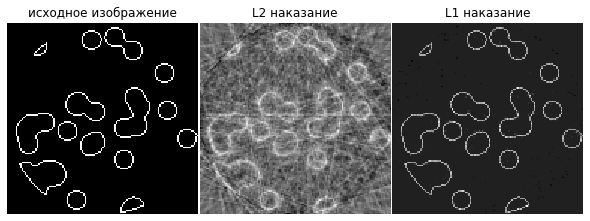

In [ ]:
plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation="nearest")
plt.axis("off")
plt.title("исходное изображение")
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L2 наказание")
plt.axis("off")
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation="nearest")
plt.title("L1 наказание")
plt.axis("off")

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)

plt.show()